In [1]:
import pandas as pd
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



In [24]:
# Let's start by modifying the Item and Bin classes as proposed

class Item:
    def __init__(self, ID, weight, height, length, width, volume, destination, orientation=(True, True, True)):
        self.ID = ID
        self.weight = weight
        self.dimensions = [int(height*10), int(length*10), int(width*10)]  # Dimensions are converted to decimeters and NOT sorted
        self.destination = destination
        self.position = [0, 0, 0]  # Default position (will be updated when the item is added to a bin)
        self.volume = volume  # Include volume as a property of the class
        self.orientation = orientation  # Orientation attribute

    @property
    def type(self):
        # Define item type based on its dimensions
        return tuple(self.dimensions)

class Bin:
    def __init__(self, ID, max_weight, height, length, width, destination):
        self.ID = ID
        self.max_weight = max_weight
        self.dimensions = [int(height*10), int(length*10), int(width*10)]  # Dimensions are converted to decimeters
        self.destination = destination
        self.grid = [[[0] * int(width*10) for _ in range(int(length*10))] for _ in range(int(height*10))]  # 3D grid (10 units = 1 cm)
        self.items = []

    @property
    def remaining_weight(self):
        # Calculate the remaining weight as the max weight minus the total weight of the items
        return self.max_weight - sum(item.weight for item in self.items)

    @property
    def remaining_volume(self):
        # Calculate the remaining volume as the bin volume minus the total volume of the items
        return self.dimensions[0] * self.dimensions[1] * self.dimensions[2] - sum(item.volume for item in self.items)

    def add_item(self, item, x, y, z):
        # Place the item in the bin at position (x, y, z)
        for i in range(x, min(x + int(item.dimensions[0]), len(self.grid))):
            for j in range(y, min(y + int(item.dimensions[1]), len(self.grid[0]))):
                for k in range(z, min(z + int(item.dimensions[2]), len(self.grid[0][0]))):
                    self.grid[i][j][k] = item.ID
        item.position = [x, y, z]  # Update the item's position
        self.items.append(item)

    def current_layer_height(self):
        # Calculate the current layer height as the maximum z-coordinate of all items in the bin
        return max(item.position[2] + item.dimensions[2] for item in self.items) if self.items else 0

    def can_accommodate(self, item, x, y, z):
        # Check whether the item fits in the bin at the specified position without exceeding the bin's dimensions
        if x + item.dimensions[0] > self.dimensions[0] or y + item.dimensions[1] > self.dimensions[1] or z + item.dimensions[2] > self.dimensions[2]:
            return False

        # Check whether the space in the bin at the specified position is currently empty
        for i in range(x, x + int(item.dimensions[0])):
            for j in range(y, y + int(item.dimensions[1])):
                for k in range(z, z + int(item.dimensions[2])):
                    if self.grid[i][j][k] != 0:
                        return False

        # If both checks pass, the item can be accommodated in the bin at the specified position
        return True

    def add_layer(self, layer, z):
        # Add a whole layer of items to the bin at height z
        x, y = 0, 0  # Starting coordinates
        for item in layer:
            if y + item.dimensions[1] > self.dimensions[1]:  # If the item doesn't fit in the current row
                y = 0  # Start a new row
                x += item.dimensions[0]  # Increase x-coordinate
            self.add_item(item, x, y, z)  # Add the item to the bin
            y += item.dimensions[1]  # Increase y-coordinate

def print_positions(bin):
    for item in bin.items:
        print(f"Item {item.ID}: {item.position}")
            
            
# Let's test the new classes by creating some items and a bin, and trying to add a layer of items to the bin

# Read the csv file
data = pd.read_csv('dummy_data3.csv')

# Create the items
items = [Item(row['ID'], row['Weight'], row['Height'], row['Length'], row['Width'], row['Volume'], row['Destination']) for _, row in data.iterrows()]

# Recreate the bin
bin = Bin(1, 1000, 3, 10, 3, "A")

# Create the layers and add them to the bin
for i in range(0, len(items), 9):  # We're creating layers of 9 items each
    layer = items[i:i+9]
    bin.add_layer(layer, bin.current_layer_height())

# Print the positions of all items in the bin
print_positions(bin)



Item 1: [0, 0, 0]
Item 2: [0, 16, 0]
Item 3: [0, 24, 0]
Item 4: [0, 35, 0]
Item 5: [0, 40, 0]
Item 6: [0, 44, 0]
Item 7: [0, 49, 0]
Item 8: [0, 57, 0]
Item 9: [0, 74, 0]
Item 10: [0, 0, 15]
Item 11: [0, 16, 15]
Item 12: [0, 31, 15]
Item 13: [0, 46, 15]
Item 14: [0, 56, 15]
Item 15: [0, 74, 15]
Item 16: [0, 77, 15]
Item 17: [18, 0, 15]
Item 18: [18, 15, 15]
Item 19: [0, 0, 33]
Item 20: [0, 6, 33]


In [25]:
# Let's modify the Item class to include an orientation attribute

class Item:
    def __init__(self, ID, weight, height, length, width, volume, destination, orientation=(True, True, True)):
        self.ID = ID
        self.weight = weight
        self.dimensions = [int(height*10), int(length*10), int(width*10)]  # Dimensions are converted to decimeters and NOT sorted
        self.destination = destination
        self.position = [0, 0, 0]  # Default position (will be updated when the item is added to a bin)
        self.volume = volume  # Include volume as a property of the class
        self.orientation = orientation  # Orientation attribute

    @property
    def type(self):
        # Define item type based on its dimensions
        return tuple(self.dimensions)  # Dimensions are returned as they are, without sorting

# Let's also modify the Bin class to consider the item's orientation when adding it to the bin

class Bin:
    def __init__(self, ID, max_weight, height, length, width, destination):
        self.ID = ID
        self.max_weight = max_weight
        self.dimensions = [int(height*10), int(length*10), int(width*10)]  # Dimensions are converted to decimeters
        self.destination = destination
        self.grid = [[[0] * int(width*10) for _ in range(int(length*10))] for _ in range(int(height*10))]  # 3D grid (10 units = 1 dm)
        self.items = []

    @property
    def remaining_weight(self):
        # Calculate the remaining weight as the max weight minus the total weight of the items
        return self.max_weight - sum(item.weight for item in self.items)

    @property
    def remaining_volume(self):
        # Calculate the remaining volume as the bin volume minus the total volume of the items
        return self.dimensions[0] * self.dimensions[1] * self.dimensions[2] - sum(item.volume for item in self.items)

    def add_item(self, item, x, y, z):
        # Check the item's orientation and sort its dimensions accordingly
        dimensions = sorted(item.dimensions) if item.orientation == (True, True, True) else item.dimensions
        # Place the item in the bin at position (x, y, z)
        for i in range(x, min(x + dimensions[0], len(self.grid))):
            for j in range(y, min(y + dimensions[1], len(self.grid[0]))):
                for k in range(z, min(z + dimensions[2], len(self.grid[0][0]))):
                    self.grid[i][j][k] = item.ID
        item.position = [x, y, z]  # Update the item's position
        self.items.append(item)

    def current_layer_height(self):
        # Calculate the current layer height as the maximum z-coordinate of all items in the bin
        return max(item.position[2] + item.dimensions[2] for item in self.items) if self.items else 0

    def can_accommodate(self, item, x, y, z):
        # Check the item's orientation and sort its dimensions accordingly
        dimensions = sorted(item.dimensions) if item.orientation == (True, True, True) else item.dimensions
        # Check whether the item fits in the bin at the specified position without exceeding the bin's dimensions
        if x + dimensions[0] > self.dimensions[0] or y + dimensions[1] > self.dimensions[1] or z + dimensions[2] > self.dimensions[2]:
            return False

        # Check whether the space in the bin at the specified position is currently empty
        for i in range(x, x + dimensions[0]):
            for j in range(y, y + dimensions[1]):
                for k in range(z, z + dimensions[2]):
                    if self.grid[i][j][k] != 0:
                        return False

        # If both checks pass, the item can be accommodated in the bin at the specified position
        return True

    def add_layer(self, layer, z):
        # Add a whole layer of items to the bin at height z
        x, y = 0, 0  # Starting coordinates
        for item in layer:
            # Check the item's orientation and sort its dimensions accordingly
            dimensions = sorted(item.dimensions) if item.orientation == (True, True, True) else item.dimensions
            if y + dimensions[1] > self.dimensions[1]:  # If the item doesn't fit in the current row
                y = 0  # Start a new row
                x += dimensions[0]  # Increase x-coordinate
            self.add_item(item, x, y, z)  # Add the item to the bin
            y += dimensions[1]  # Increase y-coordinate

def print_positions(bin):
    for item in bin.items:
        print(f"Item {item.ID}: {item.position}")
            
            
# Let's test the new classes by creating some items and a bin, and trying to add a layer of items to the bin

# Read the csv file
data = pd.read_csv('dummy_data3.csv')

# Create the items
items = [Item(row['ID'], row['Weight'], row['Height'], row['Length'], row['Width'], row['Volume'], row['Destination'], (True, True, True)) for _, row in data.iterrows()]

# Create the items
items = [Item(row['ID'], row['Weight'], row['Height'], row['Length'], row['Width'], row['Volume'], row['Destination']) for _, row in data.iterrows()]

# Recreate the bin
bin = Bin(1, 1000, 3, 10, 3, "A")

# Create the layers and add them to the bin
for i in range(0, len(items), 9):  # We're creating layers of 9 items each
    layer = items[i:i+9]
    bin.add_layer(layer, bin.current_layer_height())

# Print the positions of all items in the bin
print_positions(bin)


Item 1: [0, 0, 0]
Item 2: [0, 9, 0]
Item 3: [0, 18, 0]
Item 4: [0, 27, 0]
Item 5: [0, 32, 0]
Item 6: [0, 47, 0]
Item 7: [0, 59, 0]
Item 8: [0, 67, 0]
Item 9: [0, 83, 0]
Item 10: [0, 0, 15]
Item 11: [0, 16, 15]
Item 12: [0, 31, 15]
Item 13: [0, 46, 15]
Item 14: [0, 56, 15]
Item 15: [0, 74, 15]
Item 16: [0, 77, 15]
Item 17: [10, 0, 15]
Item 18: [10, 15, 15]
Item 19: [0, 0, 33]
Item 20: [0, 6, 33]


In [5]:
# Let's modify the Item class to include an orientation attribute

class Item:
    def __init__(self, ID, weight, height, length, width, volume, destination, orientation=(True, True, True)):
        self.ID = ID
        self.weight = weight
        self.dimensions = [int(height*10), int(length*10), int(width*10)]  # Dimensions are converted to decimeters and NOT sorted
        self.destination = destination
        self.position = [0, 0, 0]  # Default position (will be updated when the item is added to a bin)
        self.volume = volume  # Include volume as a property of the class
        self.orientation = orientation  # Orientation attribute

    @property
    def type(self):
        # Define item type based on its dimensions
        return tuple(self.dimensions)  # Dimensions are returned as they are, without sorting
    
    def is_similar_to(self, other, percentage):
        # This method will return True if all dimensions of self are within the given percentage of the corresponding dimensions of other.
        return all(
            abs(self_dim - other_dim) <= percentage / 100.0 * other_dim
            for self_dim, other_dim in zip(self.dimensions, other.dimensions)
        )

def generate_layers(items, percentage):
    # This function takes a list of items and a percentage, and generates layers by grouping similar items together.
    layers = []
    while items:
        # We start each layer with a single item.
        layer = [items.pop()]
        # We check every remaining item.
        for item in items[:]:
            # If the item is similar to the first item in the layer, we add it to the layer and remove it from the items list.
            if item.is_similar_to(layer[0], percentage):
                layer.append(item)
                items.remove(item)
        # Once we've checked all items, we add the layer to the layers list.
        layers.append(layer)
    return layers

# Let's also modify the Bin class to consider the item's orientation when adding it to the bin

class Bin:
    def __init__(self, ID, max_weight, height, length, width, destination):
        self.ID = ID
        self.max_weight = max_weight
        self.dimensions = [int(height*10), int(length*10), int(width*10)]  # Dimensions are converted to decimeters
        self.destination = destination
        self.grid = [[[0] * int(width*10) for _ in range(int(length*10))] for _ in range(int(height*10))]  # 3D grid (10 units = 1 dm)
        self.items = []

    @property
    def remaining_weight(self):
        # Calculate the remaining weight as the max weight minus the total weight of the items
        return self.max_weight - sum(item.weight for item in self.items)

    @property
    def remaining_volume(self):
        # Calculate the remaining volume as the bin volume minus the total volume of the items
        return self.dimensions[0] * self.dimensions[1] * self.dimensions[2] - sum(item.volume for item in self.items)

    def add_item(self, item, x, y, z):
        # Check the item's orientation and sort its dimensions accordingly
        dimensions = sorted(item.dimensions) if item.orientation == (True, True, True) else item.dimensions
        # Place the item in the bin at position (x, y, z)
        for i in range(x, min(x + dimensions[0], len(self.grid))):
            for j in range(y, min(y + dimensions[1], len(self.grid[0]))):
                for k in range(z, min(z + dimensions[2], len(self.grid[0][0]))):
                    self.grid[i][j][k] = item.ID
        item.position = [x, y, z]  # Update the item's position
        self.items.append(item)

    def current_layer_height(self):
        # Calculate the current layer height as the maximum z-coordinate of all items in the bin
        return max(item.position[2] + item.dimensions[2] for item in self.items) if self.items else 0

    def can_accommodate(self, item, x, y, z):
        # Check the item's orientation and sort its dimensions accordingly
        dimensions = sorted(item.dimensions) if item.orientation == (True, True, True) else item.dimensions
        # Check whether the item fits in the bin at the specified position without exceeding the bin's dimensions
        if x + dimensions[0] > self.dimensions[0] or y + dimensions[1] > self.dimensions[1] or z + dimensions[2] > self.dimensions[2]:
            return False

        # Check whether the space in the bin at the specified position is currently empty
        for i in range(x, x + dimensions[0]):
            for j in range(y, y + dimensions[1]):
                for k in range(z, z + dimensions[2]):
                    if self.grid[i][j][k] != 0:
                        return False

        # If both checks pass, the item can be accommodated in the bin at the specified position
        return True

    def add_layer(self, layer, z):
        # Add a whole layer of items to the bin at height z
        x, y = 0, 0  # Starting coordinates
        for item in layer:
            # Check the item's orientation and sort its dimensions accordingly
            dimensions = sorted(item.dimensions) if item.orientation == (True, True, True) else item.dimensions
            if y + dimensions[1] > self.dimensions[1]:  # If the item doesn't fit in the current row
                y = 0  # Start a new row
                x += dimensions[0]  # Increase x-coordinate
            self.add_item(item, x, y, z)  # Add the item to the bin
            y += dimensions[1]  # Increase y-coordinate
            
def print_positions(bin):
    for item in bin.items:
        print(f"Item {item.ID}: {item.position}")
            
            
# Let's test the new classes by creating some items and a bin, and trying to add a layer of items to the bin

# Read the csv file
data = pd.read_csv('dummy_data3.csv')

# Create the items
items = [Item(row['ID'], row['Weight'], row['Height'], row['Length'], row['Width'], row['Volume'], row['Destination'], (True, True, True)) for _, row in data.iterrows()]

# Create the items
items = [Item(row['ID'], row['Weight'], row['Height'], row['Length'], row['Width'], row['Volume'], row['Destination']) for _, row in data.iterrows()]

# Recreate the bin
bin = Bin(1, 1000, 3, 10, 3, "A")

# Generate layers of items
layers = generate_layers(items, 95)  # Use 95% similarity

# Add each layer to the bin
for layer in layers:
    bin.add_layer(layer, bin.current_layer_height())

# Print the positions of all items in the bin
print_positions(bin)


Item 20: [0, 0, 0]
Item 1: [0, 9, 0]
Item 2: [0, 18, 0]
Item 3: [0, 27, 0]
Item 4: [0, 36, 0]
Item 9: [0, 41, 0]
Item 10: [0, 45, 0]
Item 15: [0, 61, 0]
Item 16: [0, 64, 0]
Item 19: [0, 74, 0]
Item 18: [0, 0, 18]
Item 17: [0, 0, 25]
Item 5: [0, 15, 25]
Item 6: [0, 30, 25]
Item 7: [0, 42, 25]
Item 8: [0, 50, 25]
Item 11: [0, 66, 25]
Item 12: [0, 81, 25]
Item 13: [1, 0, 25]
Item 14: [1, 10, 25]


# Latest 

In [10]:
# Here are the changes to the code to implement the revised approach

class Item:
    def __init__(self, ID, weight, height, length, width, volume, destination, orientation=(True, True, True)):
        self.ID = ID
        self.weight = weight
        self.dimensions = [int(height*10), int(length*10), int(width*10)]  # Dimensions are converted to decimeters and NOT sorted
        self.destination = destination
        self.position = [0, 0, 0]  # Default position (will be updated when the item is added to a bin)
        self.volume = volume  # Include volume as a property of the class
        self.orientation = orientation  # Orientation attribute

    @property
    def type(self):
        # Define item type based on its dimensions
        return tuple(self.dimensions)  # Dimensions are returned as they are, without sorting
    
    def is_similar_to(self, other, percentage):
        # This method will return True if all dimensions of self are within the given percentage of the corresponding dimensions of other.
        return all(
            abs(self_dim - other_dim) <= percentage / 100.0 * other_dim
            for self_dim, other_dim in zip(self.dimensions, other.dimensions)
        )

class Bin:
    def __init__(self, ID, max_weight, height, length, width, destination):
        self.ID = ID
        self.max_weight = max_weight
        self.dimensions = [int(height*10), int(length*10), int(width*10)]  # Dimensions are converted to decimeters
        self.destination = destination
        self.grid = [[[0] * int(width*10) for _ in range(int(length*10))] for _ in range(int(height*10))]  # 3D grid (10 units = 1 dm)
        self.items = []

    @property
    def remaining_weight(self):
        # Calculate the remaining weight as the max weight minus the total weight of the items
        return self.max_weight - sum(item.weight for item in self.items)

    @property
    def remaining_volume(self):
        # Calculate the remaining volume as the bin volume minus the total volume of the items
        return self.dimensions[0] * self.dimensions[1] * self.dimensions[2] - sum(item.volume for item in self.items)

    def add_item(self, item, x, y, z):
        # Check the item's orientation and sort its dimensions accordingly
        dimensions = sorted(item.dimensions) if item.orientation == (True, True, True) else item.dimensions
        # Place the item in the bin at position (x, y, z)
        for i in range(x, min(x + dimensions[0], len(self.grid))):
            for j in range(y, min(y + dimensions[1], len(self.grid[0]))):
                for k in range(z, min(z + dimensions[2], len(self.grid[0][0]))):
                    self.grid[i][j][k] = item.ID
        item.position = [x, y, z]  # Update the item's position
        self.items.append(item)

    def current_layer_height(self):
        # Calculate the current layer height as the maximum z-coordinate of all items in the bin
        return max(item.position[2] + item.dimensions[2] for item in self.items) if self.items else 0

    def can_accommodate(self, item, x, y, z):
        # Check the item's orientation and sort its dimensions accordingly
        dimensions = sorted(item.dimensions) if item.orientation == (True, True, True) else item.dimensions
        # Check whether the item fits in the bin at the specified position without exceeding the bin's dimensions
        if x + dimensions[0] > self.dimensions[0] or y + dimensions[1] > self.dimensions[1] or z + dimensions[2] > self.dimensions[2]:
            return False

        # Check whether the space in the bin at the specified position is currently empty
        for i in range(x, x + dimensions[0]):
            for j in range(y, y + dimensions[1]):
                for k in range(z, z + dimensions[2]):
                    if self.grid[i][j][k] != 0:
                        return False

        # If both checks pass, the item can be accommodated in the bin at the specified position
        return True

    def add_layer(self, layer, z):
        # Add a whole layer of items to the bin at height z
        x, y = 0, 0  # Starting coordinates
        for item in layer:
            # Check the item's orientation and sort its dimensions accordingly
            dimensions = sorted(item.dimensions) if item.orientation == (True, True, True) else item.dimensions
            if y + dimensions[1] > self.dimensions[1]:  # If the item doesn't fit in the current row
                y = 0  # Start a new row
                x += dimensions[0]  # Increase x-coordinate
            self.add_item(item, x, y, z)  # Add the item to the bin
            y += dimensions[1]  # Increase y-coordinate

def generate_layers_greedy(items, percentage):
    # This function takes a list of items and a percentage, and generates layers by grouping similar items together.
    layers = []
    used_items = []  # List to keep track of items that have been added to layers
    while items:
        # We start each layer with a single item.
        layer = [items.pop(0)]
        used_items.append(layer[0])
        # We check every remaining item.
        for item in items[:]:
            # If the item is similar to the first item in the layer, we add it to the layer and remove it from the items list.
            if item.is_similar_to(layer[0], percentage) and item not in used_items:
                layer.append(item)
                items.remove(item)
                used_items.append(item)
        # Once we've checked all items, we add the layer to the layers list.
        layers.append(layer)
    return layers

def print_positions(bin):
    for item in bin.items:
        print(f"Item {item.ID}: {item.position}")

# Adjusted code for testing

# Read the csv file
data = pd.read_csv('dummy_data3.csv')

# Create the items
items = [Item(row['ID'], row['Weight'], row['Height'], row['Length'], row['Width'], row['Volume'], row['Destination'], (True, True, True)) for _, row in data.iterrows()]

# Create the bin
bin = Bin(1, 1000, 3, 10, 3, "A")

# Generate layers using the greedy approach
layers = generate_layers_greedy(items, 95)

# Add the layers to the bin
for layer in layers:
    bin.add_layer(layer, bin.current_layer_height())

# Print the positions of all items in the bin
print_positions(bin)

Item 1: [0, 0, 0]
Item 7: [0, 9, 0]
Item 13: [0, 17, 0]
Item 2: [0, 0, 3]
Item 3: [0, 9, 3]
Item 4: [0, 18, 3]
Item 5: [0, 23, 3]
Item 6: [0, 38, 3]
Item 9: [0, 50, 3]
Item 11: [0, 54, 3]
Item 15: [0, 69, 3]
Item 16: [0, 72, 3]
Item 19: [0, 82, 3]
Item 20: [0, 88, 3]
Item 8: [0, 0, 21]
Item 18: [0, 16, 21]
Item 10: [0, 0, 28]
Item 12: [0, 0, 46]
Item 14: [0, 15, 46]
Item 17: [0, 33, 46]


## Visualiser 

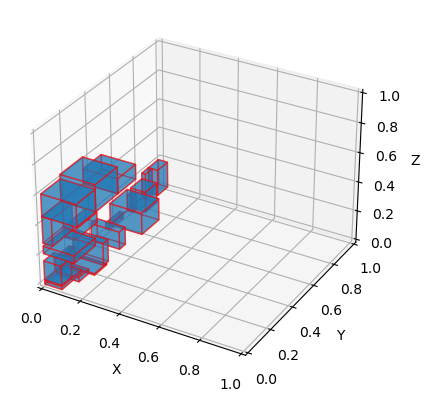

In [11]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_cube(ax, item, scale=0.01):
    x, y, z = np.array(item.position) * scale
    dx, dy, dz = np.array(item.dimensions) * scale

    # Define the vertices of the cube
    vertices = np.array([[x, y, z],
                         [x+dx, y, z],
                         [x+dx, y+dy, z],
                         [x, y+dy, z],
                         [x, y, z+dz],
                         [x+dx, y, z+dz],
                         [x+dx, y+dy, z+dz],
                         [x, y+dy, z+dz]])

    # Define the faces of the cube
    faces = [[vertices[0], vertices[1], vertices[5], vertices[4]],
             [vertices[1], vertices[2], vertices[6], vertices[5]],
             [vertices[2], vertices[3], vertices[7], vertices[6]],
             [vertices[3], vertices[0], vertices[4], vertices[7]],
             [vertices[0], vertices[1], vertices[2], vertices[3]],
             [vertices[4], vertices[5], vertices[6], vertices[7]]]

    # Plot each face
    for face in faces:
        ax.add_collection3d(Poly3DCollection([face], alpha=0.5, edgecolor='r', linewidths=1))


def visualize_bin(bin):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for item in bin.items:
        draw_cube(ax, item)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Call the function to set equal aspect ratio
    set_axes_equal(ax)

    plt.show()

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale'''
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


# Call the visualization function
visualize_bin(bin)

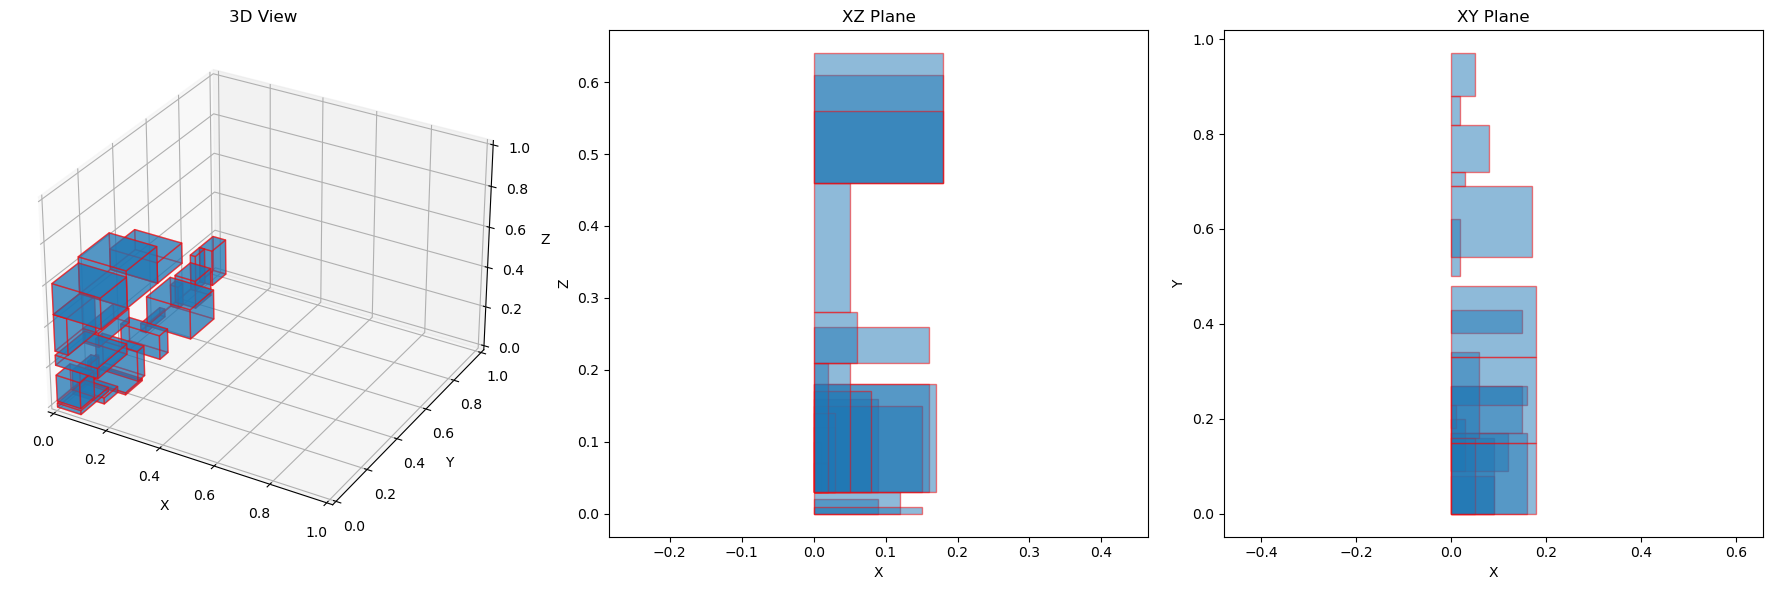

In [16]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_cube(ax, item, scale=0.01):
    x, y, z = np.array(item.position) * scale
    dx, dy, dz = np.array(item.dimensions) * scale

    # Define the vertices of the cube
    vertices = np.array([[x, y, z],
                         [x+dx, y, z],
                         [x+dx, y+dy, z],
                         [x, y+dy, z],
                         [x, y, z+dz],
                         [x+dx, y, z+dz],
                         [x+dx, y+dy, z+dz],
                         [x, y+dy, z+dz]])

    # Define the faces of the cube
    faces = [[vertices[0], vertices[1], vertices[5], vertices[4]],
             [vertices[1], vertices[2], vertices[6], vertices[5]],
             [vertices[2], vertices[3], vertices[7], vertices[6]],
             [vertices[3], vertices[0], vertices[4], vertices[7]],
             [vertices[0], vertices[1], vertices[2], vertices[3]],
             [vertices[4], vertices[5], vertices[6], vertices[7]]]

    # Plot each face
    for face in faces:
        ax.add_collection3d(Poly3DCollection([face], alpha=0.5, edgecolor='r', linewidths=1))


def visualize_bin(bin):
    fig = plt.figure(figsize=(18, 6))  # Adjust the figure size to make room for 3 subplots
    
    # 3D subplot
    ax1 = fig.add_subplot(131, projection='3d')
    for item in bin.items:
        draw_cube(ax1, item)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D View')
    set_axes_equal(ax1)

    # XZ plane subplot
    ax2 = fig.add_subplot(132)
    for item in bin.items:
        draw_rectangle(ax2, item, 'XZ')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    ax2.set_title('XZ Plane')
    ax2.axis('equal')

    # XY plane subplot
    ax3 = fig.add_subplot(133)
    for item in bin.items:
        draw_rectangle(ax3, item, 'XY')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_title('XY Plane')
    ax3.axis('equal')

    plt.tight_layout()
    plt.show()


def draw_rectangle(ax, item, plane, scale=0.01):
    if plane == 'XZ':
        x, y = np.array(item.position)[[0, 2]] * scale
        dx, dy = np.array(item.dimensions)[[0, 2]] * scale
    elif plane == 'XY':
        x, y = np.array(item.position)[[0, 1]] * scale
        dx, dy = np.array(item.dimensions)[[0, 1]] * scale

    rectangle = plt.Rectangle((x, y), dx, dy, alpha=0.5, edgecolor='r', linewidth=1)
    ax.add_patch(rectangle)    
    
    
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale'''
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])



# Call the visualization function
visualize_bin(bin)